# CREATest Experiments for ICTSS 2025

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Data Setup

In [17]:
# Read the CSV file
X = pd.read_csv('data-dynamosa/data.csv')
# X = pd.read_csv('data-whole-suite/data.csv')

# Cast to int or float everything that should be a number
X['NumStates'] = X['NumStates'].astype(int)
X['AvgDepth'] = X['AvgDepth'].astype(float)
X['MaxDepth'] = X['MaxDepth'].astype(int)
X['StandardEvosuiteCoverage'] = X['StandardEvosuiteCoverage'].astype(float)
X['StandardSCTUnitCoverage'] = X['StandardSCTUnitCoverage'].astype(float)
X['SimplifiedEvosuiteCoverage'] = X['SimplifiedEvosuiteCoverage'].astype(float)
X['SimplifiedSCTUnitCoverage'] = X['SimplifiedSCTUnitCoverage'].astype(float)

## Generate SCTUnit Test Suite

In [18]:
'''
with open("__SimplifiedTestSuite.sctunit", "w") as f:
    print("testsuite SimplifiedTestSuite {", file=f)
    for idx, stc in enumerate(X['StatechartName']):
        print("\t"+stc+"SimplifiedTest", end="", file=f)
        if idx != len(X['StatechartName'])-1:
            print(",", file = f)
    print("\n}", file=f)

with open("__StandardTestSuite.sctunit", "w") as f:
    print("testsuite StandardTestSuite {", file=f)
    for idx, stc in enumerate(X['StatechartName']):
        print("\t"+stc+"Test", end="", file=f)
        if idx != len(X['StatechartName'])-1:
            print(",", file = f)
    print("\n}", file=f)
'''

'\nwith open("__SimplifiedTestSuite.sctunit", "w") as f:\n    print("testsuite SimplifiedTestSuite {", file=f)\n    for idx, stc in enumerate(X[\'StatechartName\']):\n        print("\t"+stc+"SimplifiedTest", end="", file=f)\n        if idx != len(X[\'StatechartName\'])-1:\n            print(",", file = f)\n    print("\n}", file=f)\n\nwith open("__StandardTestSuite.sctunit", "w") as f:\n    print("testsuite StandardTestSuite {", file=f)\n    for idx, stc in enumerate(X[\'StatechartName\']):\n        print("\t"+stc+"Test", end="", file=f)\n        if idx != len(X[\'StatechartName\'])-1:\n            print(",", file = f)\n    print("\n}", file=f)\n'

## Read Numerical Information

In [19]:
standard = len(X)
standardPassed = len(X[X['StandardSCTUnitStatus'] == 'PASSED'])
standardFailed = len(X[X['StandardSCTUnitStatus'] == 'FAILED'])
standardErrors = len(X[X['StandardSCTUnitStatus'] == 'ERROR'])
standardNotGenerated = len(X[X['StandardSCTUnitStatus'] == 'NOT GENERATED'])
standardBlocked = len(X[X['StandardSCTUnitStatus'] == 'BLOCKED'])

simplified = len(X)
simplifiedPassed = len(X[X['SimplifiedSCTUnitStatus'] == 'PASSED'])
simplifiedFailed = len(X[X['SimplifiedSCTUnitStatus'] == 'FAILED'])
simplifiedErrors = len(X[X['SimplifiedSCTUnitStatus'] == 'ERROR'])
simplifiedNotGenerated = len(X[X['SimplifiedSCTUnitStatus'] == 'NOT GENERATED'])
simplifiedBlocked = len(X[X['SimplifiedSCTUnitStatus'] == 'BLOCKED'])

# Collecting general data
print(f"Standard statechars ({standard} total)")
print(f"->Num. SCTUnit classes that passed: {standardPassed}")
print(f"->Num. SCTUnit classes that failed: {standardFailed}")
print(f"->Num. SCTUnit classes with errors: {standardErrors}")
print(f"->Num. SCTUnit classes not generated: {standardNotGenerated}")
print(f"->Num. SCTUnit classes blocked: {standardBlocked}")

# Collecting general data
print(f"Simplified statechars ({simplified} total)")
print(f"->Num. SCTUnit classes that passed: {simplifiedPassed}")
print(f"->Num. SCTUnit classes that failed: {simplifiedFailed}")
print(f"->Num. SCTUnit classes with errors: {simplifiedErrors}")
print(f"->Num. SCTUnit classes not generated: {simplifiedNotGenerated}")
print(f"->Num. SCTUnit classes blocked: {simplifiedBlocked}")

Standard statechars (133 total)
->Num. SCTUnit classes that passed: 101
->Num. SCTUnit classes that failed: 27
->Num. SCTUnit classes with errors: 4
->Num. SCTUnit classes not generated: 0
->Num. SCTUnit classes blocked: 1
Simplified statechars (133 total)
->Num. SCTUnit classes that passed: 129
->Num. SCTUnit classes that failed: 1
->Num. SCTUnit classes with errors: 0
->Num. SCTUnit classes not generated: 0
->Num. SCTUnit classes blocked: 3


In [20]:
# Mean coverage without BLOCKED test classes
print(f"->Mean SCTUnit coverage: {statistics.mean(X[(X['StandardSCTUnitStatus'] != 'BLOCKED')]['StandardSCTUnitCoverage'])}")
print(f"->Mean SCTUnit coverage: {statistics.mean(X[(X['SimplifiedSCTUnitStatus'] != 'BLOCKED')]['SimplifiedSCTUnitCoverage'])}")
# Dropping irrelevant rows where 'SimplifiedSCTUnitStatus' is 'BLOCKED'
X = X[(X['SimplifiedSCTUnitStatus'] != 'BLOCKED')]


->Mean SCTUnit coverage: 0.19454545454545455
->Mean SCTUnit coverage: 0.6004615384615385


In [21]:
# Calculating correlation coefficient
correlation = X['SimplifiedEvosuiteCoverage'].corr(X['SimplifiedSCTUnitCoverage'])
print(f"Correlation coefficient between SimplifiedEvosuiteCoverage and SimplifiedSCTUnitCoverage: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['NumStates'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and NumStates: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['AvgDepth'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and AvgDepth: {correlation}")
correlation = X['SimplifiedSCTUnitCoverage'].corr(X['MaxDepth'])
print(f"Correlation coefficient between SimplifiedSCTUnitCoverage and MaxDepth: {correlation}")

Correlation coefficient between SimplifiedEvosuiteCoverage and SimplifiedSCTUnitCoverage: 0.8397664093652475
Correlation coefficient between SimplifiedSCTUnitCoverage and NumStates: -0.5646022005579345
Correlation coefficient between SimplifiedSCTUnitCoverage and AvgDepth: -0.45199639147064713
Correlation coefficient between SimplifiedSCTUnitCoverage and MaxDepth: -0.45144332773380375


## Clustering

In [22]:
# Drop columns that are useless for clustering
drop_features = [
    'StandardEvosuiteCoverage', 
    'StandardSCTUnitCoverage', 
    'StandardSCTUnitStatus', 
    'SimplifiedEvosuiteCoverage', 
    'SimplifiedSCTUnitStatus'
]
X = X.drop(drop_features, axis=1)

# Specify the columns you want to scale
columns_to_scale = ['NumStates', 'AvgDepth', 'MaxDepth']  # replace with your column names

# Create a copy of the DataFrame to avoid modifying the original
X_scaled = X.copy()

# Scale the specified columns
scaler = StandardScaler()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [23]:
# Apply the OPTICS algorithm using the scaled columns
optics_model = OPTICS(xi=0.1, min_cluster_size=10, min_samples=4)
optics_model.fit(X_scaled[columns_to_scale])

# Apply the DBSCAN algorithm using the scaled columns
dbscan_model = DBSCAN(eps=0.55, min_samples=2)
dbscan_model.fit(X_scaled[columns_to_scale])

# Apply the KMeans algorithm using the scaled columns
kmeans_model = KMeans(n_clusters=4, random_state=0, n_init="auto")
kmeans_model.fit(X_scaled[columns_to_scale])

# Change labels according to improve readability a posteriori

for i in range(len(dbscan_model.labels_)):
    val = dbscan_model.labels_[i]
    if val == 0:
        dbscan_model.labels_[i] = 0
    elif val == 2:
        dbscan_model.labels_[i] = 1
    elif val == 1:
        dbscan_model.labels_[i] = 2
    elif val == 3:
        dbscan_model.labels_[i] = 3
    elif val == 4:
        dbscan_model.labels_[i] = 4

# Adding cluster labels to the original DataFrame
X['optics_label'] = optics_model.labels_
X['dbscan_label'] = dbscan_model.labels_
X['kmeans_label'] = kmeans_model.labels_

C:\Users\nico.pellegrinelli\AppData\Roaming\Python\Python313\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [24]:
# Calculate silhouette score for each model
silhouette_optics = silhouette_score(X_scaled[columns_to_scale], optics_model.labels_)
silhouette_dbscan = silhouette_score(X_scaled[columns_to_scale], dbscan_model.labels_)
silhouette_kmeans = silhouette_score(X_scaled[columns_to_scale], kmeans_model.labels_)
print("PREFERE HIGH SILHOUTTE")
print(f"Silhouette Score (OPTICS): {silhouette_optics}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")
print(f"Silhouette Score (KMeans): {silhouette_kmeans}")

# Calculate Davies-Bouldin index for each model
db_index_optics = davies_bouldin_score(X_scaled[columns_to_scale], optics_model.labels_)
db_index_dbscan = davies_bouldin_score(X_scaled[columns_to_scale], dbscan_model.labels_)
db_index_kmeans = davies_bouldin_score(X_scaled[columns_to_scale], kmeans_model.labels_)
print("PREFERE LOW DAVIES-BOULDIN INDEX")
print(f"Davies-Bouldin Index (OPTICS): {db_index_optics}")
print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")
print(f"Davies-Bouldin Index (KMeans): {db_index_kmeans}")

PREFERE HIGH SILHOUTTE
Silhouette Score (OPTICS): 0.13855914106176773
Silhouette Score (DBSCAN): 0.6338441167555159
Silhouette Score (KMeans): 0.6303976723657677
PREFERE LOW DAVIES-BOULDIN INDEX
Davies-Bouldin Index (OPTICS): 1.2520603999577877
Davies-Bouldin Index (DBSCAN): 0.7520941808482217
Davies-Bouldin Index (KMeans): 0.6027611641106019


In [25]:
# Number of outliers in DBSCAN and number of statecharts with max coverage
n_outliers = len(X[(X['dbscan_label'] == -1)])
print(f"\nNumbers of outliers in DBSCAN: {n_outliers}")
n_max_coverage = len(X[(X['SimplifiedSCTUnitCoverage'] == 1.00)])
print(f"Numbers of completely covered statecharts: {n_max_coverage}\n")


Numbers of outliers in DBSCAN: 5
Numbers of completely covered statecharts: 26



In [26]:
# Information about each cluster
print("CLUSTER 0")
cluster_0 = X[(X['dbscan_label'] ==  0)]
print(f"Number of statecharts: {len(cluster_0)}")
print(f"Max Depth: {max(cluster_0['MaxDepth'])}")
print(f"Average NumStates: {statistics.mean(cluster_0['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_0['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_0[(cluster_0['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_0[((cluster_0['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_0['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_0[((cluster_0['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_0['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_0[(cluster_0['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

print("CLUSTER 1")
cluster_1 = X[(X['dbscan_label'] ==  1)]
print(f"Number of statecharts: {len(cluster_1)}")
print(f"Max Depth: {max(cluster_1['MaxDepth'])}")
print(f"Average NumStates: {statistics.mean(cluster_1['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_1['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_1[(cluster_1['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_1[((cluster_1['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_1['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_1[((cluster_1['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_1['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_1[(cluster_1['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

print("CLUSTER 2")
cluster_2 = X[(X['dbscan_label'] ==  2)]
print(f"Number of statecharts: {len(cluster_2)}")
print(f"Max Depth: {max(cluster_2['MaxDepth'])}")
print(f"Average NumStates: {statistics.mean(cluster_2['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_2['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_2[(cluster_2['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_2[((cluster_2['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_2['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_2[((cluster_2['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_2['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_2[(cluster_2['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

print("CLUSTER 3")
cluster_3 = X[(X['dbscan_label'] ==  3)]
print(f"Number of statecharts: {len(cluster_3)}")
print(f"Max Depth: {max(cluster_3['MaxDepth'])}")
print(f"Average NumStates: {statistics.mean(cluster_3['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_3['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_3[(cluster_3['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_3[((cluster_3['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_3['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_3[((cluster_3['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_3['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_3[(cluster_3['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

print("CLUSTER 4")
cluster_4 = X[(X['dbscan_label'] ==  4)]
print(f"Number of statecharts: {len(cluster_4)}")
print(f"Max Depth: -")
print(f"Average NumStates: {statistics.mean(cluster_4['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_4['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_4[(cluster_4['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_4[((cluster_4['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_4['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_4[((cluster_4['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_4['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_4[(cluster_4['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

print("CLUSTER -1")
cluster_m1 = X[(X['dbscan_label'] ==  -1)]
print(f"Number of statecharts: {len(cluster_m1)}")
print(f"Max Depth: {max(cluster_m1['MaxDepth'])}")
print(f"Average NumStates: {statistics.mean(cluster_m1['NumStates'])}")
print(f"Average coverage: {statistics.mean(cluster_m1['SimplifiedSCTUnitCoverage'])}")
print(f"Number of statecharts with 0% coverage: {len(cluster_m1[(cluster_m1['SimplifiedSCTUnitCoverage'] ==  0.00)])}")
print(f"Number of statecharts with 1-49% coverage: {len(cluster_m1[((cluster_m1['SimplifiedSCTUnitCoverage'] >  0.00) & (cluster_m1['SimplifiedSCTUnitCoverage'] <  0.50))])}")
print(f"Number of statecharts with 50-99% coverage: {len(cluster_m1[((cluster_m1['SimplifiedSCTUnitCoverage'] >=  0.50) & (cluster_m1['SimplifiedSCTUnitCoverage'] <  1.00))])}")
print(f"Number of statecharts with 100% coverage: {len(cluster_m1[(cluster_m1['SimplifiedSCTUnitCoverage'] ==  1.00)])}")

CLUSTER 0
Number of statecharts: 48
Max Depth: 1
Average NumStates: 3.6041666666666665
Average coverage: 0.7579166666666667
Number of statecharts with 0% coverage: 4
Number of statecharts with 1-49% coverage: 5
Number of statecharts with 50-99% coverage: 19
Number of statecharts with 100% coverage: 20
CLUSTER 1
Number of statecharts: 33
Max Depth: 2
Average NumStates: 5.393939393939394
Average coverage: 0.6709090909090909
Number of statecharts with 0% coverage: 4
Number of statecharts with 1-49% coverage: 3
Number of statecharts with 50-99% coverage: 20
Number of statecharts with 100% coverage: 6
CLUSTER 2
Number of statecharts: 23
Max Depth: 3
Average NumStates: 9.304347826086957
Average coverage: 0.5460869565217391
Number of statecharts with 0% coverage: 2
Number of statecharts with 1-49% coverage: 6
Number of statecharts with 50-99% coverage: 15
Number of statecharts with 100% coverage: 0
CLUSTER 3
Number of statecharts: 9
Max Depth: 3
Average NumStates: 21.11111111111111
Average co

## Plots

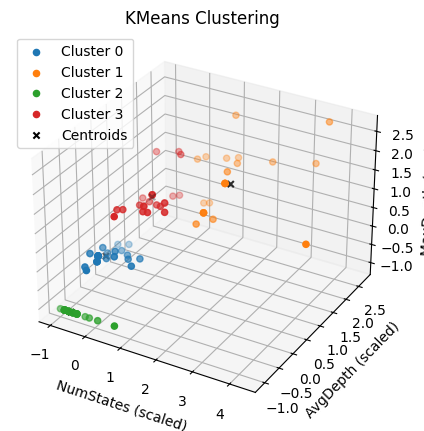

In [27]:
# Plot for KMeans 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in range(kmeans_model.n_clusters):
    cluster_mask = (kmeans_model.labels_ == cluster_label)
    ax.scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                X_scaled.loc[cluster_mask, 'AvgDepth'], 
                X_scaled.loc[cluster_mask, 'MaxDepth'], 
                label=f'Cluster {cluster_label}')
ax.scatter(kmeans_model.cluster_centers_[:, 0], 
            kmeans_model.cluster_centers_[:, 1], 
            kmeans_model.cluster_centers_[:, 2], 
            marker='x', color='black', label='Centroids')
ax.set_title('KMeans Clustering')
ax.set_xlabel('NumStates (scaled)')
ax.set_ylabel('AvgDepth (scaled)')
ax.set_zlabel('MaxDepth (scaled)')
ax.legend()

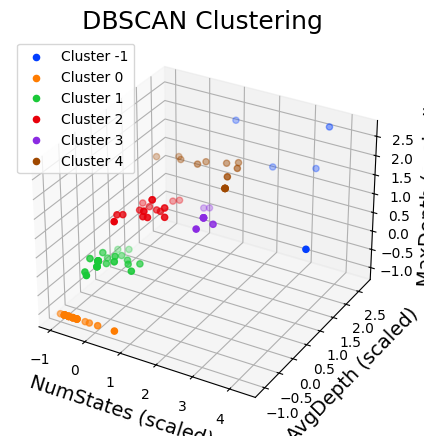

In [28]:
# Generate colors for each DBSCAN cluster
unique_labels = np.unique(dbscan_model.labels_)
colors = sns.color_palette('bright', len(unique_labels))

# Plot for DBSCAN in 3D
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
for cluster_label, color in zip(unique_labels, colors):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    ax.scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                X_scaled.loc[cluster_mask, 'AvgDepth'], 
                X_scaled.loc[cluster_mask, 'MaxDepth'], 
                label=f'Cluster {cluster_label}', color=color)
ax.set_title('DBSCAN Clustering', fontsize=18)
ax.set_xlabel('NumStates (scaled)', fontsize=14)
ax.set_ylabel('AvgDepth (scaled)', fontsize=14)
ax.set_zlabel('MaxDepth (scaled)', fontsize=14)
ax.legend()

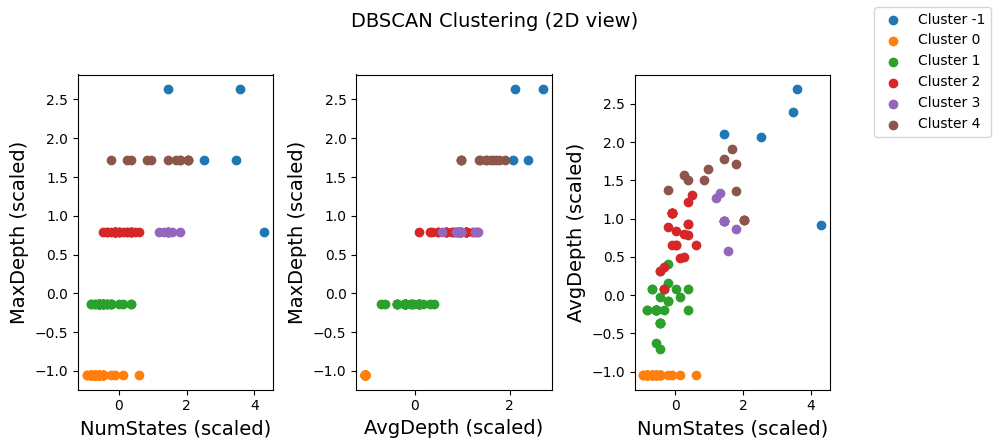

In [29]:
# Create subplots in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(10, 4.5))
fig.suptitle('DBSCAN Clustering (2D view)', fontsize=14)  # overall title

# --- Subplot 1: NumStates vs MaxDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[0].scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                   X_scaled.loc[cluster_mask, 'MaxDepth'], 
                   label=f'Cluster {cluster_label}')
axs[0].set_xlabel('NumStates (scaled)', fontsize=14)
axs[0].set_ylabel('MaxDepth (scaled)', fontsize=14)

# --- Subplot 2: AvgDepth vs MaxDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[1].scatter(X_scaled.loc[cluster_mask, 'AvgDepth'], 
                   X_scaled.loc[cluster_mask, 'MaxDepth'], 
                   label=f'Cluster {cluster_label}')
axs[1].set_xlabel('AvgDepth (scaled)', fontsize=14)
axs[1].set_ylabel('MaxDepth (scaled)', fontsize=14)

# --- Subplot 3: NumStates vs AvgDepth ---
for cluster_label in np.unique(dbscan_model.labels_):
    cluster_mask = (dbscan_model.labels_ == cluster_label)
    axs[2].scatter(X_scaled.loc[cluster_mask, 'NumStates'], 
                   X_scaled.loc[cluster_mask, 'AvgDepth'], 
                   label=f'Cluster {cluster_label}')
axs[2].set_xlabel('NumStates (scaled)', fontsize=14)
axs[2].set_ylabel('AvgDepth (scaled)', fontsize=14)

# Create one overall legend using handles from the first subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

# Adjust layout so the overall title and legend are not overlapped
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show(block=False)


C:\Users\nico.pellegrinelli\AppData\Local\Temp\ipykernel_10680\1934073472.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dbscan_label', y='SimplifiedSCTUnitCoverage', data=X_sorted, palette=palette)


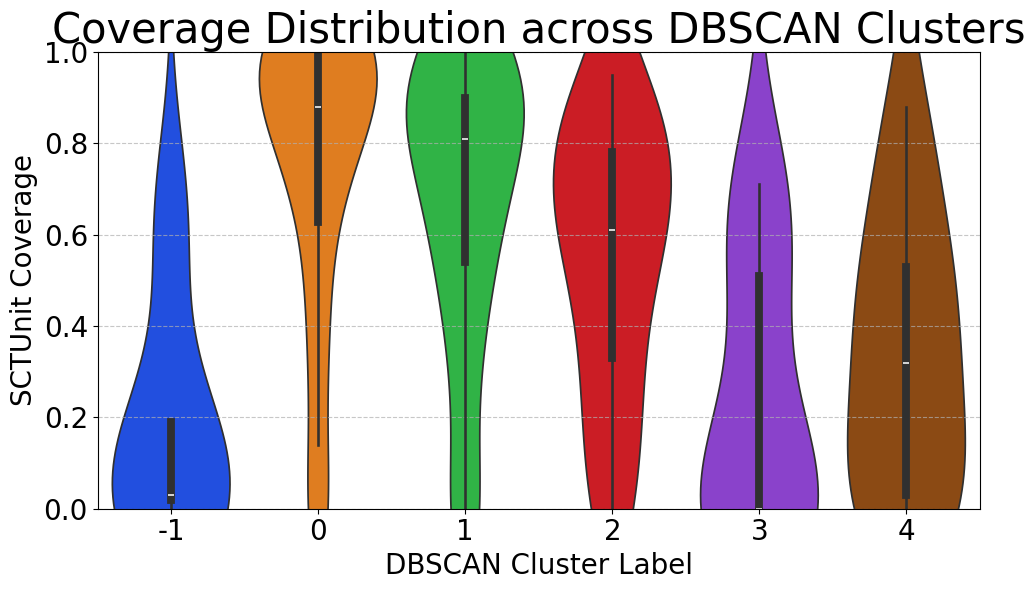

In [30]:
# Coverage Analysis for DBSCAN
# Analyze coverage within DBSCAN clusters
cluster_coverage_stats = X.groupby('dbscan_label')['SimplifiedSCTUnitCoverage'].describe()
# Create a custom color palette for the violin plot with string keys
palette = {str(label): color for label, color in zip(unique_labels, colors)}
# Sort the data by 'dbscan_label' in ascending order
X_sorted = X.sort_values(by='dbscan_label')
# Convert 'dbscan_label' to string type (for the palette)
X['dbscan_label'] = X['dbscan_label'].astype(str)
# Visualize coverage distribution within a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='dbscan_label', y='SimplifiedSCTUnitCoverage', data=X_sorted, palette=palette)
plt.ylim(0, 1)  # Limit y-axis from 0 to 1
plt.title('Coverage Distribution across DBSCAN Clusters', fontsize=30)
plt.xlabel('DBSCAN Cluster Label', fontsize=20)
plt.ylabel('SCTUnit Coverage', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
# Show plot
plt.tight_layout()
plt.show()